In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 32.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.10.0
    Uninstalling typing_extensions-4.10.0:
      Successfully uninstalled typing_extensions-4.10.0
  Attempting un

In [ ]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=97d78dafa279dc2493a0199e930572cd9fc773cc4e0a0fe4a44137d4928d7796
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/spam_ham_dataset.csv')
df.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
df.dtypes

Unnamed: 0     int64
label         object
text          object
label_num      int64
dtype: object

In [ ]:
df = df.drop(columns=['Unnamed: 0', 'label'])

In [ ]:
df.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


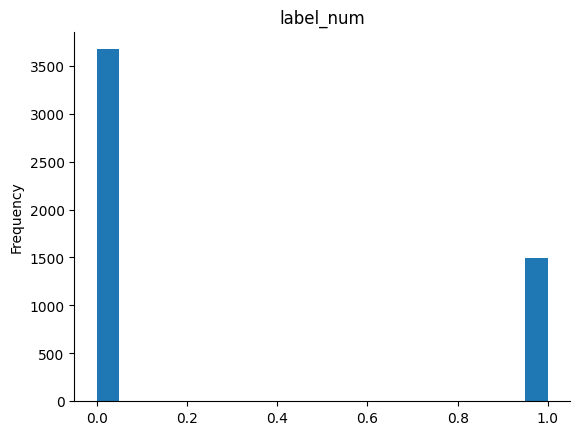

In [ ]:
from matplotlib import pyplot as plt
df['label_num'].plot(kind='hist', bins=20, title='label_num')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_ham = df[df['label_num'] == 0]
df_spam= df[df['label_num'] == 1]

In [ ]:
df_ham_sample = df_ham.sample(n=df_spam.shape[0])

In [ ]:
import pandas as pd
df_concat = pd.concat([df_ham_sample, df_spam])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_concat.drop('label_num', axis=1),
    df_concat['label_num'],
    test_size=0.2,
    random_state=42,
    stratify=df_concat['label_num']
)

In [ ]:
X_train.shape , y_train.shape

((2398, 1), (2398,))

In [ ]:
X_test.shape , y_test.shape

((600, 1), (600,))

In [ ]:
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

In [ ]:
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-128-a-2/versions/2")

In [ ]:
text_test = ['Noyon loves sumu']
text_preprocess = preprocessor(text_test)
text_preprocess.keys()

dict_keys(['input_type_ids', 'input_mask', 'input_word_ids'])

In [ ]:
encoded_text = encoder(text_preprocess)
encoded_text['pooled_output']

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.70227706,  0.9642087 , -0.05113976, -0.8892446 , -0.97618866,
         0.62977505, -0.38319847,  0.12813681,  0.9715736 , -0.5531277 ,
        -0.8505143 ,  0.91921526,  0.9561225 ,  0.9624411 , -0.01716047,
         0.89088535, -0.9995543 , -0.50102854, -0.5183286 ,  0.98751473,
        -0.9157748 , -0.6951537 , -0.52015233,  0.9532813 , -0.92005026,
         0.952763  ,  0.44042954, -0.9778993 , -0.34821424, -0.94849753,
         0.9883419 ,  0.9761985 ,  0.9870569 ,  0.8191674 ,  0.8398278 ,
        -0.00670006, -0.9845282 , -0.6578537 ,  0.12173861,  0.20925608,
        -0.80652833, -0.9454809 ,  0.11244181,  0.99874246, -0.48522228,
        -0.85722643,  0.26097184, -0.85023797,  0.7553451 ,  0.97820157,
        -0.503584  , -0.9674083 , -0.07070127,  0.10285219, -0.03855113,
        -0.6972794 ,  0.15073961,  0.11402161, -0.92987233,  0.94547075,
        -0.9989656 ,  0.05481495,  0.73975486, -0.0080776 , -0.90969133,
 

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
encoder_inputs = preprocessor(text_input)
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
model = tf.keras.Model(inputs = [text_input], outputs = [net])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')

]
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = METRICS)

In [ ]:
model.fit(X_train, y_train, epochs = 5)

Epoch 1/5
75/75 [==============================] - 61s 691ms/step - loss: 0.7232 - accuracy: 0.4825 - precision: 0.4811 - recall: 0.4462
Epoch 2/5
75/75 [==============================] - 57s 755ms/step - loss: 0.6777 - accuracy: 0.5713 - precision: 0.5722 - recall: 0.5655
Epoch 3/5
75/75 [==============================] - 52s 699ms/step - loss: 0.6475 - accuracy: 0.6243 - precision: 0.6377 - recall: 0.5755
Epoch 4/5
75/75 [==============================] - 55s 741ms/step - loss: 0.6121 - accuracy: 0.6776 - precision: 0.6895 - recall: 0.6464
Epoch 5/5
75/75 [==============================] - 52s 696ms/step - loss: 0.6024 - accuracy: 0.6889 - precision: 0.6989 - recall: 0.6639


In [ ]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 14s 698ms/step - loss: 0.5831 - accuracy: 0.7133 - precision: 0.7254 - recall: 0.6867


[0.5831104516983032,
 0.7133333086967468,
 0.7253521084785461,
 0.6866666674613953]

In [ ]:
import numpy as np

y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

19/19 [==============================] - 14s 691ms/step


array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)

Text(50.722222222222214, 0.5, 'Truth')

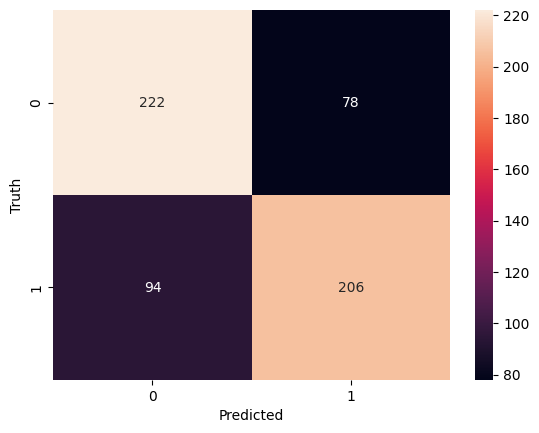

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')